# Data Assesing

In [ ]:
import zipfile

# Ekstrak dataset
with zipfile.ZipFile("brain-tumor-mri-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
dataset_path = "dataset"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")

classes = os.listdir(train_path)
print("Kelas yang tersedia:", classes)

Kelas yang tersedia: ['notumor', 'pituitary', 'glioma', 'meningioma']


In [ ]:
for cls in classes:
    print(f"Jumlah gambar di kelas {cls} (train):", len(os.listdir(os.path.join(train_path, cls))))
    print(f"Jumlah gambar di kelas {cls} (test):", len(os.listdir(os.path.join(test_path, cls))))


Jumlah gambar di kelas notumor (train): 1595
Jumlah gambar di kelas notumor (test): 405
Jumlah gambar di kelas pituitary (train): 1457
Jumlah gambar di kelas pituitary (test): 300
Jumlah gambar di kelas glioma (train): 1321
Jumlah gambar di kelas glioma (test): 300
Jumlah gambar di kelas meningioma (train): 1339
Jumlah gambar di kelas meningioma (test): 306


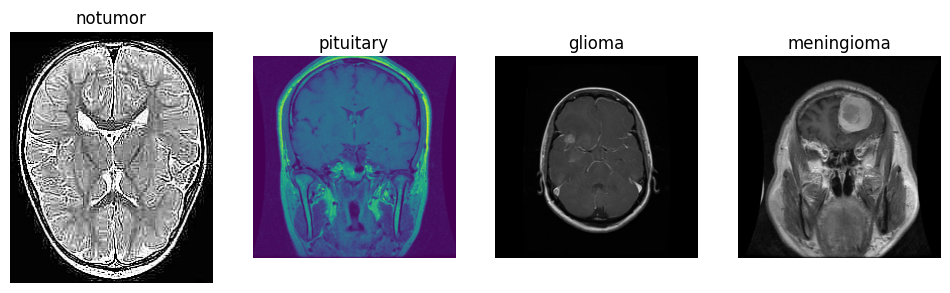

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i, cls in enumerate(classes):
    img_path = os.path.join(train_path, cls, os.listdir(os.path.join(train_path, cls))[0])
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis("off")
plt.show()

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Original Images

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False  # Transfer learning, hanya melatih lapisan atas

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 210ms/step - accuracy: 0.4495 - loss: 1.3409 - val_accuracy: 0.6354 - val_loss: 1.0363
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.6008 - loss: 0.9089 - val_accuracy: 0.6556 - val_loss: 0.9543
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.6314 - loss: 0.8588 - val_accuracy: 0.6801 - val_loss: 0.9181
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.6502 - loss: 0.7985 - val_accuracy: 0.6722 - val_loss: 0.8919
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.6781 - loss: 0.7727 - val_accuracy: 0.7003 - val_loss: 0.8956
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.6585 - loss: 0.7631 - val_accuracy: 0.6880 - val_loss: 0.8748
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.6770 - loss: 0.7441 - val_accuracy: 0.7134 - val_loss: 0.8122
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.6898 - loss: 0.6965 - val

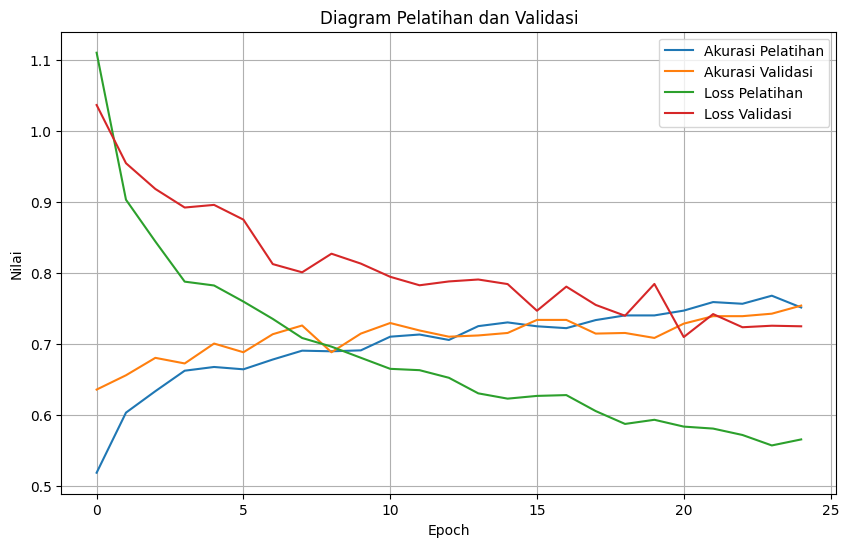

In [ ]:
# Visualisasikan riwayat pelatihan
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Diagram Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()

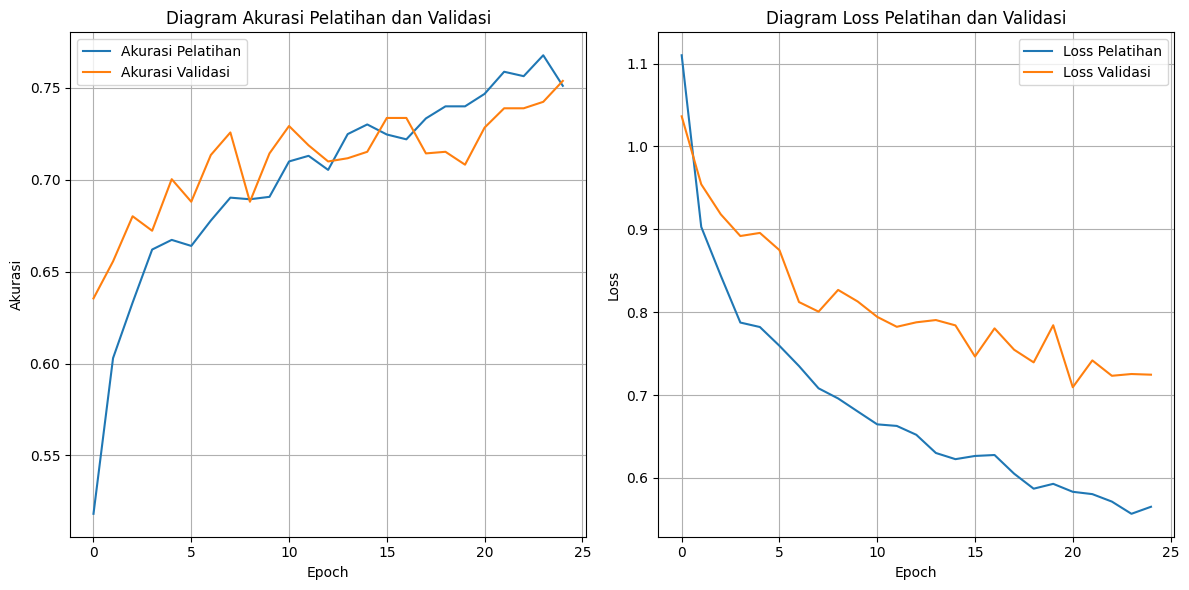

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.6941 - loss: 0.7252

Loss pada data uji: 0.5733
Akurasi pada data uji: 0.7727


In [ ]:
# Pisahkan plot untuk akurasi dan loss
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Diagram Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Diagram Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluasi model pada data uji
loss, accuracy = model.evaluate(test_generator)
print(f"\nLoss pada data uji: {loss:.4f}")
print(f"Akurasi pada data uji: {accuracy:.4f}")

In [ ]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 244ms/step
Classification Report:
               precision    recall  f1-score   support

     notumor       0.73      0.70      0.72       300
   pituitary       0.63      0.48      0.54       306
      glioma       0.87      0.91      0.89       405
  meningioma       0.78      0.96      0.86       300

    accuracy                           0.77      1311
   macro avg       0.75      0.76      0.75      1311
weighted avg       0.76      0.77      0.76      1311



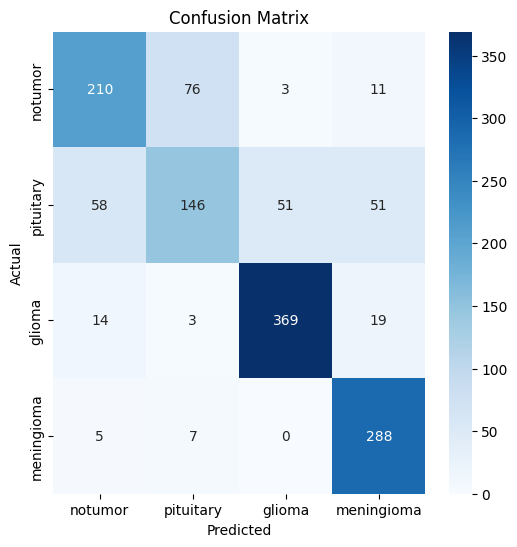

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("brain_tumor_resnet50.h5")
print("Model telah disimpan!")

Model telah disimpan!


# Clahe Images

In [ ]:
import cv2

def apply_clahe(img):
    # Pastikan img dalam rentang [0, 255] dan tipe uint8
    img = (img * 255).astype(np.uint8)

    # Konversi dari RGB ke BGR
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # Konversi ke grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # Terapkan CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl_img = clahe.apply(gray)
    # Ubah kembali ke RGB
    cl_img_rgb = cv2.cvtColor(cl_img, cv2.COLOR_GRAY2RGB)

    # Kembalikan ke float32 [0, 1]
    return cl_img_rgb.astype(np.float32) / 255.0



Visualisasi sebelum dan sesudah CLAHE:


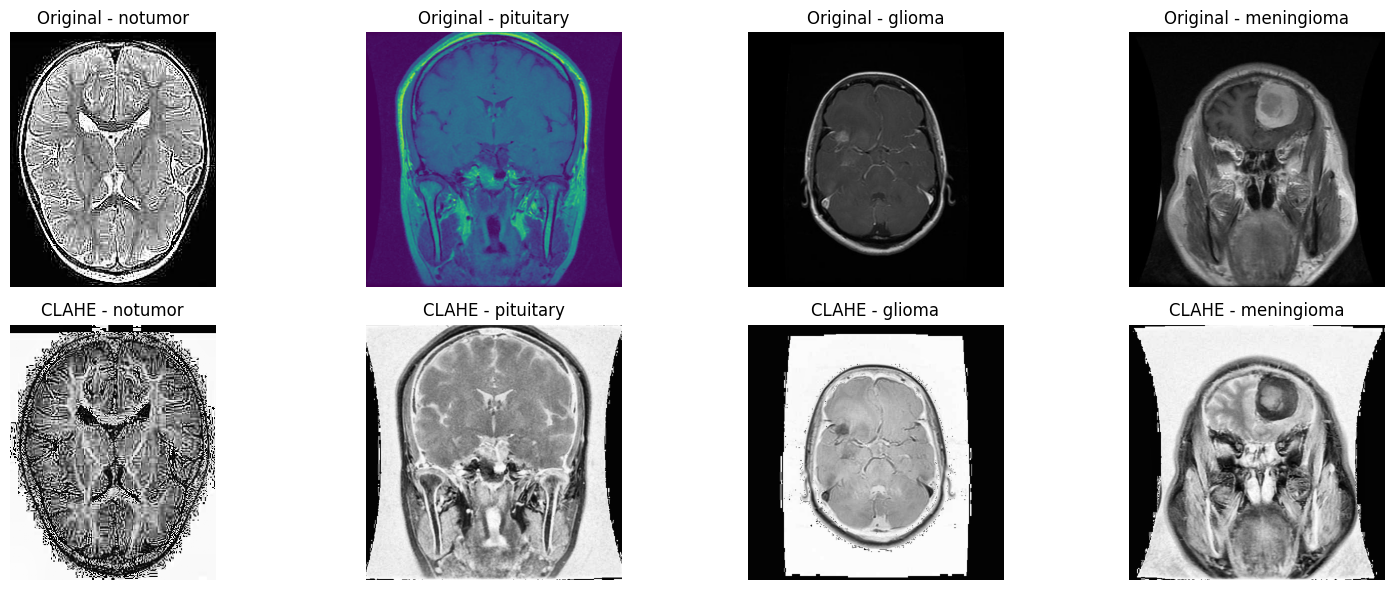

In [ ]:
print("\nVisualisasi sebelum dan sesudah CLAHE:")
fig, axes = plt.subplots(2, 4, figsize=(16, 6))  # 2 baris, 4 kolom

for idx, cls in enumerate(classes):
    row = 0  # Baris pertama untuk gambar asli
    col = idx

    img_path = os.path.join(train_path, cls, os.listdir(os.path.join(train_path, cls))[0])
    img = plt.imread(img_path)

    # Gambar asli
    axes[row][col].imshow(img)
    axes[row][col].set_title(f"Original - {cls}")
    axes[row][col].axis("off")

    # Gambar setelah CLAHE (di baris kedua)
    img_clahe = apply_clahe(img)
    axes[row + 1][col].imshow(img_clahe)
    axes[row + 1][col].set_title(f"CLAHE - {cls}")
    axes[row + 1][col].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe,
    validation_split=0.2
)

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=apply_clahe)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False  # Transfer learning, hanya melatih lapisan atas

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.5178 - loss: 1.3551 - val_accuracy: 0.7923 - val_loss: 0.7198
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.7834 - loss: 0.6057 - val_accuracy: 0.7888 - val_loss: 0.6727
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.8237 - loss: 0.5190 - val_accuracy: 0.7993 - val_loss: 0.6528
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.8422 - loss: 0.4671 - val_accuracy: 0.8011 - val_loss: 0.6259
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.8325 - loss: 0.4802 - val_accuracy: 0.7975 - val_loss: 0.6069
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.8511 - loss: 0.4314 - val_accuracy: 0.7984 - val_loss: 0.5856
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.8672 - loss: 0.3939 - val_accuracy: 0.7975 - val_loss: 0.5762
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.8701 - loss: 0.3671 - val

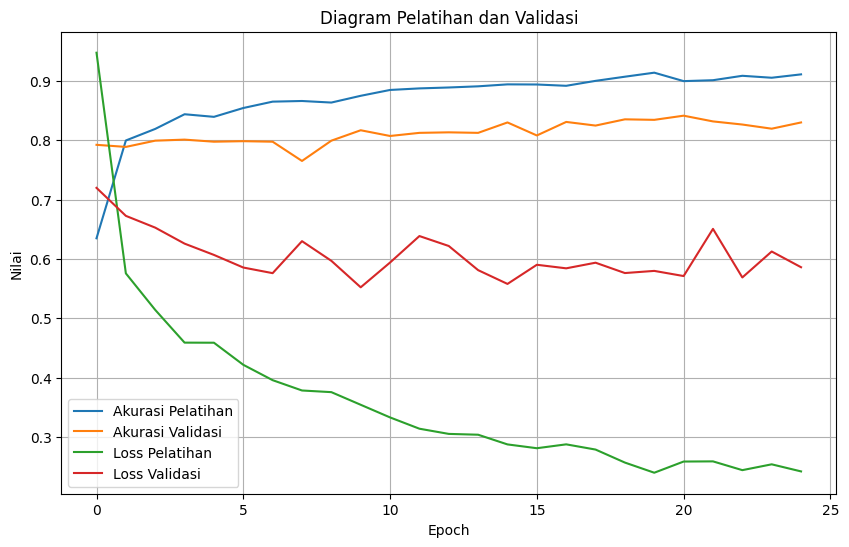

In [ ]:
# Visualisasikan riwayat pelatihan
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Diagram Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()

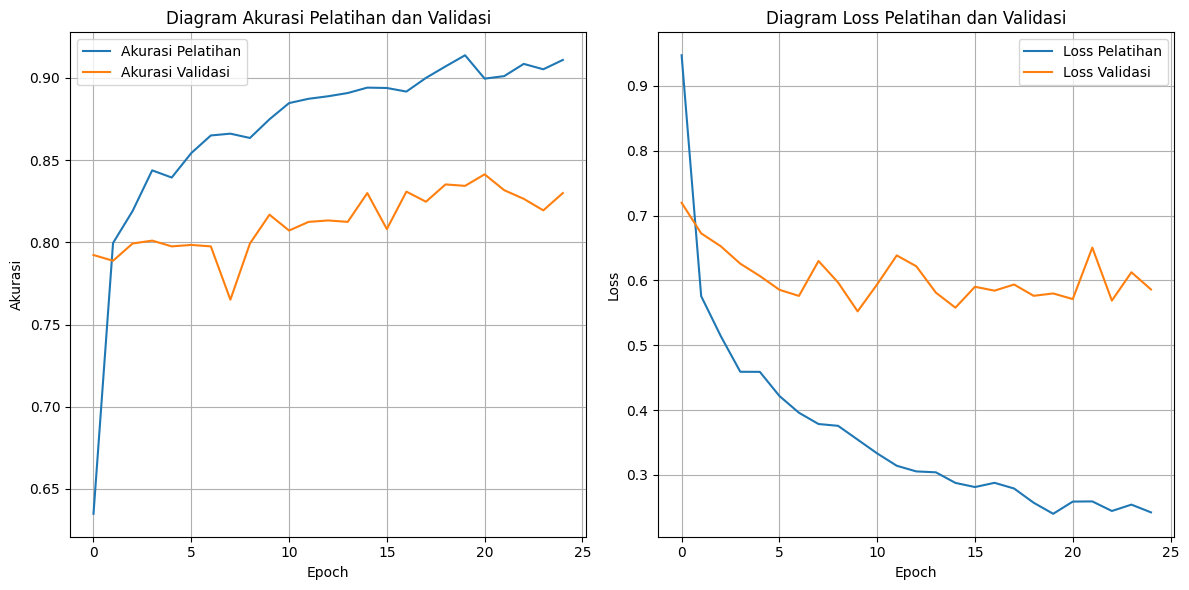

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.7958 - loss: 0.5551

Loss pada data uji: 0.3932
Akurasi pada data uji: 0.8574


In [ ]:
# Pisahkan plot untuk akurasi dan loss
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Diagram Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Diagram Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluasi model pada data uji
loss, accuracy = model.evaluate(test_generator)
print(f"\nLoss pada data uji: {loss:.4f}")
print(f"Akurasi pada data uji: {accuracy:.4f}")

In [ ]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step
Classification Report:
               precision    recall  f1-score   support

     notumor       0.96      0.78      0.86       300
   pituitary       0.74      0.64      0.69       306
      glioma       0.87      0.99      0.93       405
  meningioma       0.86      0.98      0.91       300

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.85      1311
weighted avg       0.86      0.86      0.85      1311



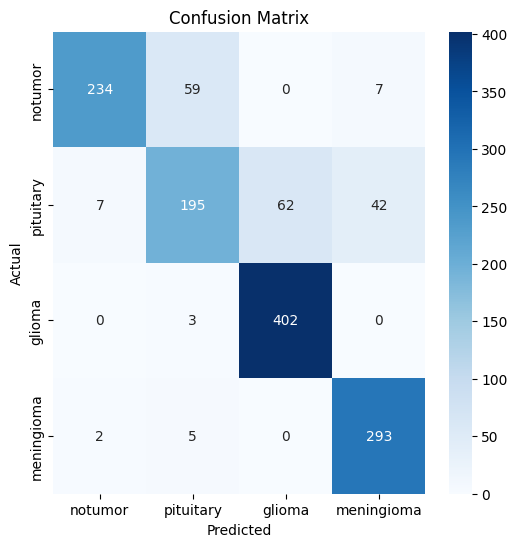

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("brain_tumor_resnet50_clahe.h5")
print("Model telah disimpan!")

Model telah disimpan!


# Gaussian Blur

In [ ]:
import cv2

def apply_gaussian_blur(img):
    # Pastikan format uint8 sebelum diproses OpenCV
    img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img
    # Terapkan Gaussian Blur
    blurred = cv2.GaussianBlur(img, (5, 5), sigmaX=0)
    # Ubah ke float kembali
    return blurred.astype(np.float32) / 255.0



Visualisasi sebelum dan sesudah Gaussian Blur:


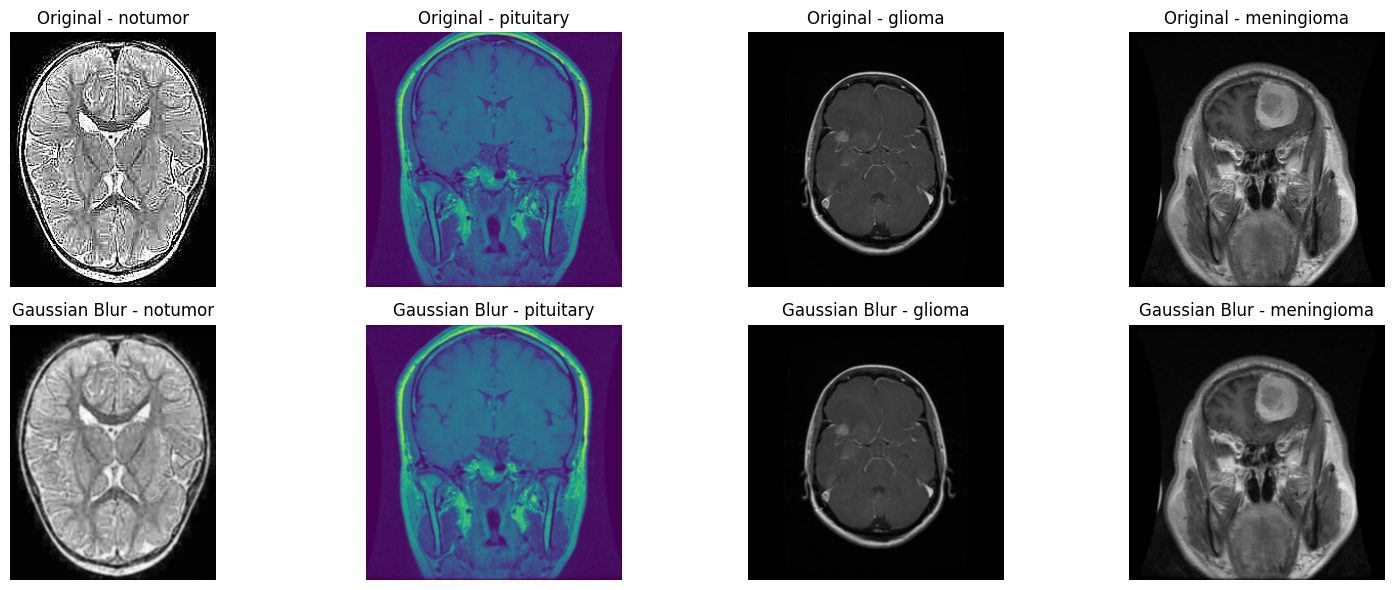

In [ ]:
print("\nVisualisasi sebelum dan sesudah Gaussian Blur:")
fig, axes = plt.subplots(2, 4, figsize=(16, 6))  # 2 baris, 4 kolom

for idx, cls in enumerate(classes):
    row = 0  # Baris pertama untuk gambar asli
    col = idx

    img_path = os.path.join(train_path, cls, os.listdir(os.path.join(train_path, cls))[0])
    img = plt.imread(img_path)

    # Gambar asli
    axes[row][col].imshow(img)
    axes[row][col].set_title(f"Original - {cls}")
    axes[row][col].axis("off")

    # Gambar setelah GB (di baris kedua)
    img_clahe = apply_gaussian_blur(img)
    axes[row + 1][col].imshow(img_clahe)
    axes[row + 1][col].set_title(f"Gaussian Blur - {cls}")
    axes[row + 1][col].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=apply_gaussian_blur,
    validation_split=0.2
)

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=apply_gaussian_blur)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False  # Transfer learning, hanya melatih lapisan atas

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 212ms/step - accuracy: 0.3821 - loss: 1.5094 - val_accuracy: 0.6310 - val_loss: 1.1342
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.4988 - loss: 1.0864 - val_accuracy: 0.6582 - val_loss: 1.0843
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.5617 - loss: 0.9830 - val_accuracy: 0.6643 - val_loss: 1.0140
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.5802 - loss: 0.9391 - val_accuracy: 0.6740 - val_loss: 0.9894
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6102 - loss: 0.9043 - val_accuracy: 0.7064 - val_loss: 0.9331
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.6231 - loss: 0.8832 - val_accuracy: 0.7082 - val_loss: 0.9164
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.6364 - loss: 0.8339 - val_accuracy: 0.7169 - val_loss: 0.8841
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.6408 - loss: 0.8139 - val

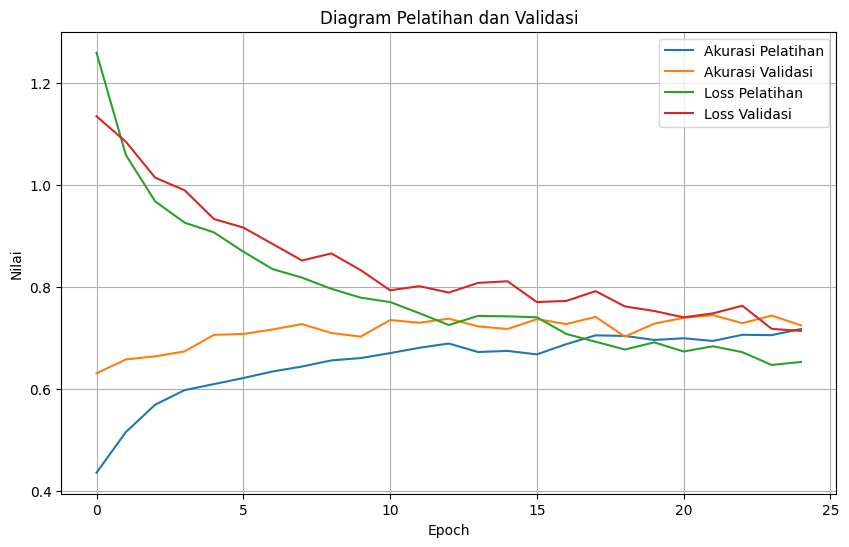

In [ ]:
# Visualisasikan riwayat pelatihan
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Diagram Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()

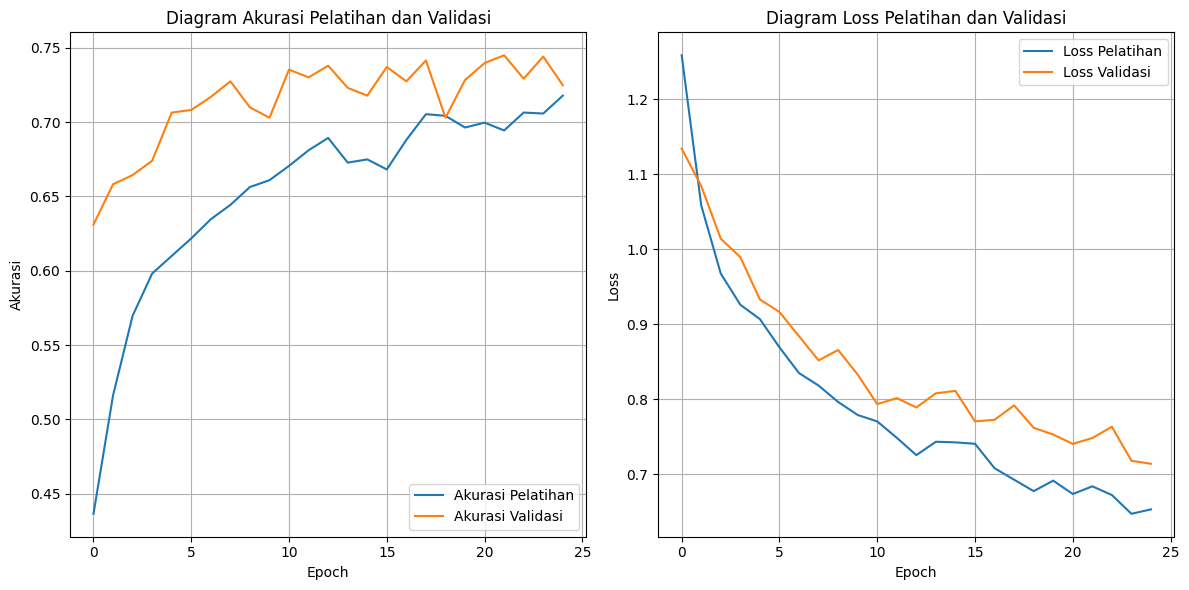

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.6624 - loss: 0.7971

Loss pada data uji: 0.6398
Akurasi pada data uji: 0.7437


In [ ]:
# Pisahkan plot untuk akurasi dan loss
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Diagram Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Diagram Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluasi model pada data uji
loss, accuracy = model.evaluate(test_generator)
print(f"\nLoss pada data uji: {loss:.4f}")
print(f"Akurasi pada data uji: {accuracy:.4f}")

In [ ]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step
Classification Report:
               precision    recall  f1-score   support

     notumor       0.73      0.69      0.71       300
   pituitary       0.55      0.44      0.49       306
      glioma       0.82      0.89      0.85       405
  meningioma       0.80      0.92      0.85       300

    accuracy                           0.74      1311
   macro avg       0.72      0.73      0.73      1311
weighted avg       0.73      0.74      0.73      1311



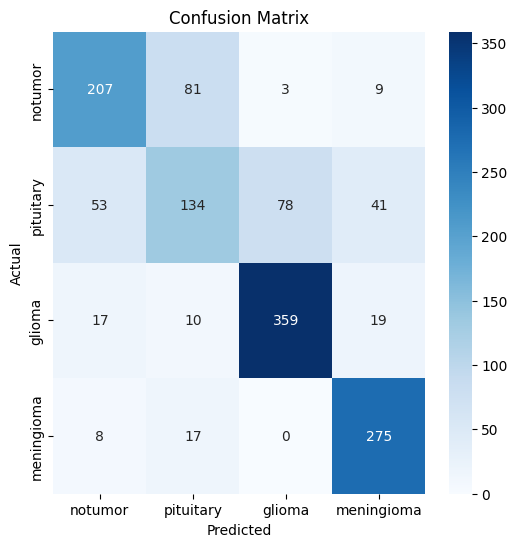

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("brain_tumor_resnet50_GB.h5")
print("Model telah disimpan!")

Model telah disimpan!
